# Problem Statement: Fake Celebrity Image Generation Using a Simple GAN Architecture

---

## Objective:
Implement a simple Generative Adversarial Network (GAN) architecture consisting of a Generator (G) and Discriminator (D) modules, both as 2D Convolutional Neural Networks (CNNs). Generate fake celebrity images using the trained GAN and compute the cross-entropy loss between actual celebrity images and those generated by the Generator.

---

## Background:
Generative Adversarial Networks (GANs) are deep learning models used for generating synthetic data that resembles real data distributions. In this context, the goal is to generate fake celebrity images that closely resemble real ones. Celebrity images are widely available and can be used to train and evaluate the performance of the GAN.

---

## Task Description:
1. Design and implement a GAN architecture with a Generator and Discriminator using 2D CNNs.
2. Train the GAN on the provided dataset of celebrity images (Face Mask Lite Dataset from Kaggle).
3. Generate fake celebrity images using the trained Generator.
4. Compute the cross-entropy loss between actual celebrity images and those generated by the Generator.
5. Analyze the impact of latent vector dimension on generator loss. Experiment by varying the latent vector dimension(s) as multiples of the image dimension.

---

## Requirements:
- Develop a GAN architecture suitable for generating fake celebrity images.
- Preprocess the celebrity image dataset for training.
- Implement the cross-entropy loss computation between actual and generated celebrity images.
- Utilize ConvTranspose2d layers for upsampling the latent vector noise.
- Evaluate the impact of latent vector dimension on generator loss.

---

## Resources:
- [Face Mask Lite Dataset](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset) available on Kaggle.
- Deep learning framework with support for Convolutional Neural Networks.

---

## Deliverables:
1. Codebase containing the GAN implementation and training scripts.
2. Documentation detailing the architecture, training procedure, and evaluation metrics.
3. Evaluation results including the computed cross-entropy loss and analysis of latent vector dimension impact on generator loss.

---

## Evaluation Criteria:
- Quality of generated fake celebrity images.
- Accuracy of cross-entropy loss computation.
- Clarity and organization of the documentation.
- Effectiveness of latent vector dimension analysis.

---
verify the robustness of the trained model.


# The models are being Trained on a very small about of the actual data set as computational resources are not enough to process the images


In [6]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image

# Define Generator
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = torchvision.io.read_image(img_name).float()  # Read image as float tensor
        if self.transform:
            image = self.transform(image)
        return image

# Function to initialize weights of the neural network models
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
nz = 100  # Size of latent vector
ngf = 64  # Number of features in the generator
ndf = 64  # Number of features in the discriminator
nc = 3    # Number of channels in the input images (RGB)
batch_size = 64
lr = 0.0002
num_epochs = 10
sample_interval = 200

# Create dataset and dataloader
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CustomDataset(root_dir="img", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create Generator and Discriminator instances
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

# Initialize weights for Generator and Discriminator
netG.apply(weights_init)
netD.apply(weights_init)

# Binary cross-entropy loss function
criterion = nn.BCELoss()

# Optimizers
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # Train Discriminator
        ############################
        netD.zero_grad()
        real_images = data.to(device)
        batch_size = real_images.size(0)
        label = torch.full((batch_size,), 1, dtype=torch.float, device=device)

        # Forward pass real images through Discriminator
        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(0)

        # Forward pass fake images through Discriminator
        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # Train Generator
        ############################
        netG.zero_grad()
        label.fill_(1)  # fake labels are real for generator cost
        output = netD(fake_images).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Print statistics
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


[0/10][0/2]	Loss_D: 2.0009	Loss_G: 2.4216	D(x): 0.2972	D(G(z)): 0.3512 / 0.1097
[1/10][0/2]	Loss_D: 0.9368	Loss_G: 6.3723	D(x): 1.0000	D(G(z)): 0.5395 / 0.0027
[2/10][0/2]	Loss_D: 0.1123	Loss_G: 6.0322	D(x): 0.9999	D(G(z)): 0.1001 / 0.0037
[3/10][0/2]	Loss_D: 0.0743	Loss_G: 7.2066	D(x): 0.9997	D(G(z)): 0.0655 / 0.0012
[4/10][0/2]	Loss_D: 0.1938	Loss_G: 7.5550	D(x): 0.9962	D(G(z)): 0.1594 / 0.0008
[5/10][0/2]	Loss_D: 0.0741	Loss_G: 7.2726	D(x): 0.9912	D(G(z)): 0.0614 / 0.0010
[6/10][0/2]	Loss_D: 0.0637	Loss_G: 7.5113	D(x): 0.9920	D(G(z)): 0.0528 / 0.0008
[7/10][0/2]	Loss_D: 0.0844	Loss_G: 8.4511	D(x): 0.9925	D(G(z)): 0.0695 / 0.0004
[8/10][0/2]	Loss_D: 0.1088	Loss_G: 8.8672	D(x): 0.9920	D(G(z)): 0.0891 / 0.0002
[9/10][0/2]	Loss_D: 0.0411	Loss_G: 7.6335	D(x): 0.9886	D(G(z)): 0.0285 / 0.0009


# Question 5

Latent Dimension Factor: 1, Epoch: 1, Generator Loss: 15.2399
Latent Dimension Factor: 1, Epoch: 2, Generator Loss: 8.7709
Latent Dimension Factor: 1, Epoch: 3, Generator Loss: 2.6154
Latent Dimension Factor: 1, Epoch: 4, Generator Loss: 0.0932
Latent Dimension Factor: 1, Epoch: 5, Generator Loss: 0.0116
Latent Dimension Factor: 1, Epoch: 6, Generator Loss: 0.0062
Latent Dimension Factor: 1, Epoch: 7, Generator Loss: 0.0046
Latent Dimension Factor: 1, Epoch: 8, Generator Loss: 0.0038
Latent Dimension Factor: 1, Epoch: 9, Generator Loss: 0.0035
Latent Dimension Factor: 1, Epoch: 10, Generator Loss: 0.0027
Latent Dimension Factor: 2, Epoch: 1, Generator Loss: 14.7356
Latent Dimension Factor: 2, Epoch: 2, Generator Loss: 8.0960
Latent Dimension Factor: 2, Epoch: 3, Generator Loss: 1.8328
Latent Dimension Factor: 2, Epoch: 4, Generator Loss: 0.0497
Latent Dimension Factor: 2, Epoch: 5, Generator Loss: 0.0078
Latent Dimension Factor: 2, Epoch: 6, Generator Loss: 0.0042
Latent Dimension Fact

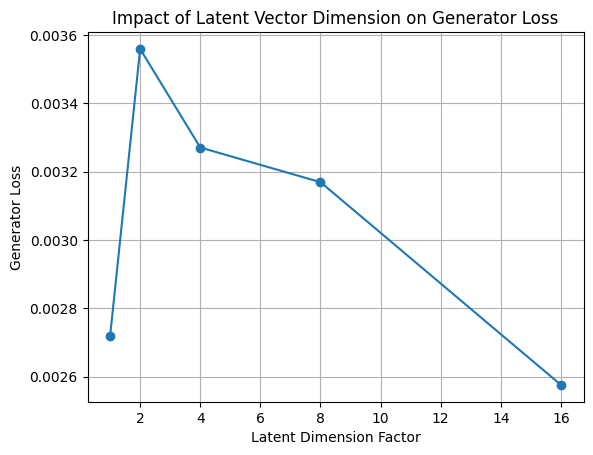

In [8]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# Define Generator
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = torchvision.io.read_image(img_name).float()  # Read image as float tensor
        if self.transform:
            image = self.transform(image)
        return image

# Function to initialize weights of the neural network models
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
ngf = 64  # Number of features in the generator
nc = 3    # Number of channels in the input images (RGB)
batch_size = 64
lr = 0.0002
num_epochs = 10
sample_interval = 200

# Create dataset and dataloader
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CustomDataset(root_dir="img", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Varying latent vector dimension as a multiple of image dimension
latent_dim_factors = [1, 2, 4, 8, 16]

# Lists to store generator losses for each latent dimension
generator_losses = []

# Iterate over different latent vector dimensions
for latent_dim_factor in latent_dim_factors:
    nz = 64 * latent_dim_factor  # Latent vector dimension

    # Create Generator instance
    netG = Generator(nz, ngf, nc).to(device)

    # Initialize weights for Generator
    netG.apply(weights_init)

    # Binary cross-entropy loss function
    criterion = nn.BCELoss()

    # Optimizer
    optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            ############################
            # Train Generator
            ############################
            netG.zero_grad()
            label = torch.full((batch_size,), 1, dtype=torch.float, device=device)

            # Generate fake images
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = netG(noise)
            output = netD(fake_images).view(-1)

            # Generator loss
            errG = criterion(output, label)
            errG.backward()
            optimizerG.step()

            # Accumulate generator loss
            running_loss += errG.item()

        # Print average generator loss for each epoch
        avg_loss = running_loss / len(dataloader)
        print('Latent Dimension Factor: {}, Epoch: {}, Generator Loss: {:.4f}'.format(latent_dim_factor, epoch+1, avg_loss))
    
    # Store the generator loss for this latent dimension factor
    generator_losses.append(avg_loss)

# Plot the impact of latent vector dimension on generator loss
plt.plot(latent_dim_factors, generator_losses, marker='o')
plt.xlabel('Latent Dimension Factor')
plt.ylabel('Generator Loss')
plt.title('Impact of Latent Vector Dimension on Generator Loss')
plt.grid(True)
plt.show()


Epoch [100/10000], Discriminator Loss: 1.3866
Epoch [200/10000], Discriminator Loss: 1.3859
Epoch [300/10000], Discriminator Loss: 1.3859
Epoch [400/10000], Discriminator Loss: 1.3859
Epoch [500/10000], Discriminator Loss: 1.3857
Epoch [600/10000], Discriminator Loss: 1.3856
Epoch [700/10000], Discriminator Loss: 1.3855
Epoch [800/10000], Discriminator Loss: 1.3853
Epoch [900/10000], Discriminator Loss: 1.3853
Epoch [1000/10000], Discriminator Loss: 1.3852
Epoch [1100/10000], Discriminator Loss: 1.3850
Epoch [1200/10000], Discriminator Loss: 1.3849
Epoch [1300/10000], Discriminator Loss: 1.3850
Epoch [1400/10000], Discriminator Loss: 1.3845
Epoch [1500/10000], Discriminator Loss: 1.3841
Epoch [1600/10000], Discriminator Loss: 1.3840
Epoch [1700/10000], Discriminator Loss: 1.3837
Epoch [1800/10000], Discriminator Loss: 1.3820
Epoch [1900/10000], Discriminator Loss: 1.3836
Epoch [2000/10000], Discriminator Loss: 1.3837
Epoch [2100/10000], Discriminator Loss: 1.3821
Epoch [2200/10000], Di

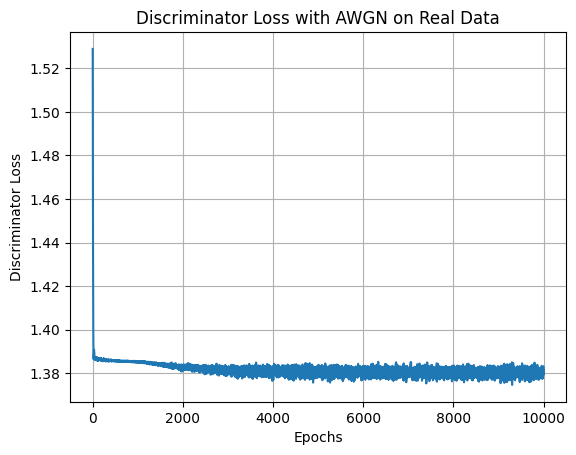

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Function to generate real data with AWGN
def generate_real_data(mu, sigma, num_samples):
    real_data = torch.normal(mu, sigma, size=(num_samples, 1))
    return real_data

# Function to train the discriminator
def train_discriminator(discriminator, real_data, noise_sigma, num_epochs):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
    discriminator_losses = []

    for epoch in range(num_epochs):
        # Generate real data with AWGN
        noisy_real_data = real_data + torch.randn_like(real_data) * noise_sigma

        # Train discriminator
        discriminator.zero_grad()
        real_labels = torch.ones(len(real_data), 1)
        fake_labels = torch.zeros(len(real_data), 1)

        real_output = discriminator(real_data)
        real_loss = criterion(real_output, real_labels)

        fake_output = discriminator(noisy_real_data)
        fake_loss = criterion(fake_output, fake_labels)

        total_loss = real_loss + fake_loss
        total_loss.backward()
        optimizer.step()

        discriminator_losses.append(total_loss.item())

        # Print discriminator loss for every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Discriminator Loss: {total_loss.item():.4f}")

    return discriminator_losses

# Parameters
mu = 5.0  # Mean of the real data
sigma = 1.0  # Standard deviation of the real data
num_samples = 1000  # Number of samples in real data
noise_sigma = 0.5  # Standard deviation of AWGN
num_epochs = 10000  # Number of epochs

# Generate real data
real_data = generate_real_data(mu, sigma, num_samples)

# Initialize discriminator
input_size = 1
discriminator = Discriminator(input_size)

# Train discriminator with AWGN
discriminator_losses = train_discriminator(discriminator, real_data, noise_sigma, num_epochs)

# Plot discriminator loss over epochs
plt.plot(discriminator_losses)
plt.xlabel('Epochs')
plt.ylabel('Discriminator Loss')
plt.title('Discriminator Loss with AWGN on Real Data')
plt.grid(True)
plt.show()
